In [20]:
# --- Step 1: ライブラリの読み込みとパス定義 ---

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

# パス定義
DATA_DIR = Path('../../data/circle-text')
CSV_PATH = DATA_DIR / 'metadata.csv'
IMG_DIR = DATA_DIR / 'images'

# デバイス設定（MPS > CUDA > CPU）
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("Using device:", device)

Using device: mps


In [21]:
# --- Step 2: 動的ペア生成型Datasetの実装 ---

import random

class DynamicPairRankingDataset(Dataset):
    """
    ランキング付き画像リストから、ランダムな画像ペアとラベル（0, 1, 2）を返すDataset
    0: 左(img1)が良い, 1: 右(img2)が良い, 2: 同等
    """
    def __init__(self, csv_path, img_dir, transform=None, indices=None):
        self.df = pd.read_csv(csv_path)
        if indices is not None:
            self.df = self.df.iloc[indices].reset_index(drop=True)
        self.img_dir = Path(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        idx1, idx2 = random.sample(range(len(self.df)), 2)
        row1 = self.df.iloc[idx1]
        row2 = self.df.iloc[idx2]

        img1_path = self.img_dir / f"img_{int(row1['id'])}.png"
        img2_path = self.img_dir / f"img_{int(row2['id'])}.png"
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if row1['score'] > row2['score']:
            label = 0  # 左(img1)が良い
        elif row1['score'] < row2['score']:
            label = 1  # 右(img2)が良い
        else:
            label = 2  # 同等

        return img1, img2, label

In [22]:
# --- Step 3: モデル定義 ---

class PairwiseRankingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128), nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 2, 64), nn.ReLU(),
            nn.Linear(64, 3)  # 3クラス（左が良い・右が良い・同等）
        )

    def forward(self, img1, img2):
        feat1 = self.feature(img1)
        feat2 = self.feature(img2)
        x = torch.cat([feat1, feat2], dim=1)
        out = self.classifier(x)
        return out  # (B, 3)

# 画像前処理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [23]:
# --- Step 4: 損失関数と最適化 ---

model = PairwiseRankingNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [24]:
# --- Step 5: データ分割とDataLoader ---

df = pd.read_csv(CSV_PATH)
train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

train_dataset = DynamicPairRankingDataset(CSV_PATH, IMG_DIR, transform=transform, indices=train_idx)
val_dataset = DynamicPairRankingDataset(CSV_PATH, IMG_DIR, transform=transform, indices=val_idx)

# DataLoaderのnum_workersはMPSの場合0にするのが安全です
num_workers = 0 if str(device) == "mps" else 2

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [25]:
# --- Step 6: 学習ループ ---

from tqdm import tqdm

EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    running_train_loss = 0.0

    for img1, img2, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]"):
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, label.long())
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * img1.size(0)

    avg_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # 検証
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, label in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]"):
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs, label.long())
            running_val_loss += loss.item() * img1.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == label).sum().item()
            total += label.size(0)

    avg_val_loss = running_val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

Epoch 1/10 [val]: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch 1: Train Loss=0.7970, Val Loss=0.6930, Val Acc=0.5550


Epoch 2/10 [val]: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]


Epoch 2: Train Loss=0.6768, Val Loss=0.6131, Val Acc=0.8250


Epoch 3/10 [val]: 100%|██████████| 7/7 [00:06<00:00,  1.04it/s]


Epoch 3: Train Loss=0.5392, Val Loss=0.4492, Val Acc=0.8450


Epoch 4/10 [val]: 100%|██████████| 7/7 [00:05<00:00,  1.30it/s]


Epoch 4: Train Loss=0.3417, Val Loss=0.4066, Val Acc=0.7850


Epoch 5/10 [val]: 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]


Epoch 5: Train Loss=0.2985, Val Loss=0.3485, Val Acc=0.8550


Epoch 6/10 [val]: 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]


Epoch 6: Train Loss=0.2791, Val Loss=0.2956, Val Acc=0.8750


Epoch 7/10 [val]: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]


Epoch 7: Train Loss=0.2499, Val Loss=0.3293, Val Acc=0.8400


Epoch 8/10 [val]: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Epoch 8: Train Loss=0.2843, Val Loss=0.2443, Val Acc=0.8800


Epoch 9/10 [val]: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]


Epoch 9: Train Loss=0.2781, Val Loss=0.2365, Val Acc=0.8950


Epoch 10/10 [val]: 100%|██████████| 7/7 [00:04<00:00,  1.40it/s]

Epoch 10: Train Loss=0.2619, Val Loss=0.2922, Val Acc=0.8600


/var/folders/82/rz249n3147399xtr8mt3lczm0000gn/T/ipykernel_19523/3344164710.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


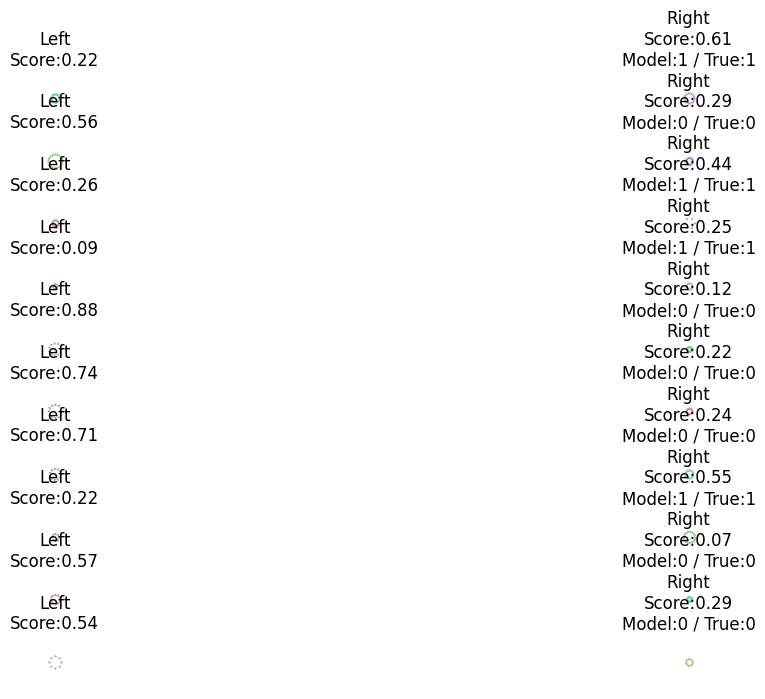

In [26]:
# --- Step 7: 検証データからランダムなペアを選び、モデルの判定と正解を画像付きで表示 ---

import random

n_samples = 10
val_df = df.iloc[val_idx].reset_index(drop=True)
indices = list(range(len(val_df)))
sample_pairs = [random.sample(indices, 2) for _ in range(n_samples)]

def judge_pair(img1_path, img2_path, model, transform, device):
    model.eval()
    img1 = transform(Image.open(img1_path).convert('RGB')).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img1, img2)
        pred = output.argmax(dim=1).item()
    return pred  # 0:左, 1:右, 2:同等

plt.figure(figsize=(15, 8))
for i, (idx1, idx2) in enumerate(sample_pairs):
    row1 = val_df.iloc[idx1]
    row2 = val_df.iloc[idx2]
    img1_path = IMG_DIR / f"img_{int(row1['id'])}.png"
    img2_path = IMG_DIR / f"img_{int(row2['id'])}.png"
    # 推論
    result = judge_pair(img1_path, img2_path, model, transform, device)
    # 正解ラベル
    if row1['score'] > row2['score']:
        true_label = 0
    elif row1['score'] < row2['score']:
        true_label = 1
    else:
        true_label = 2

    # 画像表示
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    plt.subplot(n_samples, 2, 2*i+1)
    plt.imshow(img1)
    plt.axis("off")
    plt.title(f"Left\nScore:{row1['score']:.2f}")
    plt.subplot(n_samples, 2, 2*i+2)
    plt.imshow(img2)
    plt.axis("off")
    plt.title(f"Right\nScore:{row2['score']:.2f}\n"
              f"Model:{result} / True:{true_label}")

plt.tight_layout()
plt.show()

In [27]:
# --- Step 8: 任意の2枚の画像で判定する推論関数 ---

def judge_pair(img1_path, img2_path, model, transform, device):
    """
    画像パス2つを受け取って、どちらが良いか判定する関数
    0: 左が良い, 1: 右が良い, 2: 同等
    """
    model.eval()
    img1 = transform(Image.open(img1_path).convert('RGB')).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img1, img2)
        pred = output.argmax(dim=1).item()
    return pred

# 使い方例
# result = judge_pair("path/to/img1.png", "path/to/img2.png", model, transform, device)
# print("判定:", result)

In [ ]:
# --- Step 8: ギャルの推論関数だよ！好きな2枚でどっちがイケてるか即判定しちゃう！---

def gal_judge(img1_path, img2_path, model, transform, device):
    """
    画像パス2つを受け取って、どっちがイケてるかギャルが判定するよ！
    -1: 左が良い, 0: 同じ, 1: 右が良い
    """
    model.eval()
    img1 = transform(Image.open(img1_path).convert('RGB')).unsqueeze(0).to(device)
    img2 = transform(Image.open(img2_path).convert('RGB')).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img1, img2)
        pred = output.argmax(dim=1).item()
    if pred == 0:
        return -1  # 左が良い
    elif pred == 1:
        return 0   # 同じ
    else:
        return 1   # 右が良い

# 使い方例（パスは適宜変更してね！）
# result = gal_judge("path/to/img1.png", "path/to/img2.png", model, transform, device)
# print("ギャル判定:", result)

In [28]:
# --- Step 9: 検証データ全体でペアごとに勝敗を集計し、推定ランキングを作成 ---

import numpy as np

val_df = df.iloc[val_idx].reset_index(drop=True)
val_ids = val_df['id'].tolist()
val_scores = val_df['score'].tolist()
n_val = len(val_ids)

# 勝ち数をカウントする行列
win_matrix = np.zeros((n_val, n_val), dtype=int)

with torch.no_grad():
    for i in range(n_val):
        for j in range(n_val):
            if i == j:
                continue
            img1_path = IMG_DIR / f"img_{int(val_ids[i])}.png"
            img2_path = IMG_DIR / f"img_{int(val_ids[j])}.png"
            img1 = transform(Image.open(img1_path).convert('RGB')).unsqueeze(0).to(device)
            img2 = transform(Image.open(img2_path).convert('RGB')).unsqueeze(0).to(device)
            output = model(img1, img2)
            pred = output.argmax(dim=1).item()
            if pred == 0:  # 左が良い
                win_matrix[i, j] += 1
            elif pred == 1:  # 右が良い
                win_matrix[j, i] += 1
            # pred==2（同等）はカウントしない

# 各画像の勝ち数でランキング推定
win_counts = win_matrix.sum(axis=1)
pred_ranking = np.argsort(-win_counts)  # 勝ち数が多い順

# 元のスコア順ランキング
true_ranking = np.argsort(-np.array(val_scores))

# スピアマン順位相関でランキング精度を評価
from scipy.stats import spearmanr
corr, _ = spearmanr(pred_ranking, true_ranking)
print(f"推定ランキングと正解ランキングの順位相関（スピアマン）: {corr:.4f}")

推定ランキングと正解ランキングの順位相関（スピアマン）: -0.0037
